In [ ]:
import pandas as pd
import os
import zipfile
import json
import spacy
import re
import requests
!pip install seaborn -q
import seaborn as sns
!pip install autocorrect -q
from autocorrect import Speller
import numpy as np
from sklearn.metrics import f1_score
import re
import torch
import string
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, classification_report
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, GlobalMaxPooling1D, Masking, TimeDistributed
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.8/622.8 kB 11.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


# Corpus

We have preparared a small version of EXIST dataset in our dedicated [Github repository](https://github.com/lt-nlp-lab-unibo/nlp-course-material/tree/main/2024-2025/Assignment%201/data).

Check the `Assignment 1/data` folder. It contains 3 `.json` files representing `training`, `validation` and `test` sets.

The three sets are slightly unbalanced, with a bias toward the `Non-sexist` class.



### Dataset Description
- The dataset contains tweets in both English and Spanish.
- There are labels for multiple tasks, but we are focusing on **Task 1**.
- For Task 1, soft labels are assigned by six annotators.
- The labels for Task 1 represent whether the tweet is sexist ("YES") or not ("NO").






### Instructions
1. **Download** the `Assignment 1/data` folder.
2. **Load** the three JSON files and encode them as pandas dataframes.
3. **Generate hard labels** for Task 1 using majority voting and store them in a new dataframe column called `hard_label_task1`. Items without a clear majority will be removed from the dataset.
4. **Filter the DataFrame** to keep only rows where the `lang` column is `'en'`.
5. **Remove unwanted columns**: Keep only `id_EXIST`, `lang`, `tweet`, and `hard_label_task1`.
6. **Encode the `hard_label_task1` column**: Use 1 to represent "YES" and 0 to represent "NO".

In [ ]:
def download_folder(folder_url, destination_folder):
    # Download folder from github

    api_url = folder_url.replace("github.com", "api.github.com/repos").replace("/tree/main/", "/contents/")

    os.makedirs(destination_folder, exist_ok=True)

    response = requests.get(api_url)
    if response.status_code != 200:
        print(f"Error: Unable to fetch folder contents. Status Code: {response.status_code}")
        return

    files = response.json()
    for file in files:
        if file["name"].endswith(".json"):  # Download only JSON files
            file_url = file["download_url"]
            file_name = file["name"]
            file_path = os.path.join(destination_folder, file_name)

            print(f"Downloading {file_name} from {file_url}...")
            file_response = requests.get(file_url)
            if file_response.status_code == 200:
                with open(file_path, "wb") as f:
                    f.write(file_response.content)
                print(f"Saved {file_name} to {destination_folder}.")
            else:
                print(f"Failed to download {file_name}. Status Code: {file_response.status_code}")

    print("Download complete.")


In [ ]:
def load_json_files(data_folder):
    # Load json files to dataframes

    dataframes = {}

    json_files = [file for file in os.listdir(data_folder) if file.endswith(".json")]

    for json_file in json_files:
        file_path = os.path.join(data_folder, json_file)
        print(f"Loading {json_file} as DataFrame...")
        df = pd.read_json(file_path)
        dataframes[json_file.replace(".json", "")] = df

    return dataframes


In [ ]:
folder_url = "https://github.com/nlp-unibo/nlp-course-material/tree/main/2024-2025/Assignment%201/data"
destination_folder = "./data"

download_folder(folder_url, destination_folder)


Saved test.json to ./data.
Saved training.json to ./data.
Saved validation.json to ./data.
Download complete.


In [ ]:
data_folder_path = "./data"

dataframes = load_json_files(data_folder_path)

Loading test.json as DataFrame...
Loading training.json as DataFrame...
Loading validation.json as DataFrame...


In [ ]:
# Create train, validation and test dataframes
for file_name, df in dataframes.items():
    if file_name == "training":
      train_df = df.copy()
    elif file_name == "validation":
      val_df = df.copy()
    else:
      test_df = df.copy()

In [ ]:
# Define majority function
def get_majority_label(labels):
    yes_count = labels.count("YES")
    no_count = labels.count("NO")

    if yes_count > no_count:
        return "YES"
    elif no_count > yes_count:
        return "NO"
    else:
        return None

In [ ]:
# DO pre processing for instructions 3,4,5,6
def pre_processing(data:pd.DataFrame):
    data = data.T
    data["hard_label_task1"] = data["labels_task1"].apply(get_majority_label)
    data = data[data["hard_label_task1"].notna()]
    data = data[data["lang"]=="en"]
    data = data[["id_EXIST","lang","tweet","hard_label_task1"]]
    data["hard_label_task1"] = data["hard_label_task1"].replace({"YES": 1, "NO": 0})
    return data

In [ ]:
# Pre processing dataframes
train_df = pre_processing(train_df)
val_df = pre_processing(val_df)
test_df = pre_processing(test_df)

<ipython-input-8-ad385bbc0040>:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["hard_label_task1"] = data["hard_label_task1"].replace({"YES": 1, "NO": 0})
<ipython-input-8-ad385bbc0040>:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["hard_label_task1"] = data["hard_label_task1"].replace({"YES": 1, "NO": 0})
<ipython-input-8-ad385bbc0040>:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False

In [ ]:
print("Processed Train DataFrame:")
train_df.head()

Processed Train DataFrame:


,id_EXIST,lang,tweet,hard_label_task1
200002,200002,en,Writing a uni essay in my local pub with a cof...,1
200003,200003,en,@UniversalORL it is 2021 not 1921. I dont appr...,1
200006,200006,en,According to a customer I have plenty of time ...,1
200007,200007,en,"So only 'blokes' drink beer? Sorry, but if you...",1
200008,200008,en,New to the shelves this week - looking forward...,0


In [ ]:
print("\nProcessed Validation DataFrame:")
val_df.head()


Processed Validation DataFrame:


,id_EXIST,lang,tweet,hard_label_task1
400001,400001,en,"@Mike_Fabricant “You should smile more, love. ...",0
400002,400002,en,@BBCWomansHour @LabWomenDec @EverydaySexism Sh...,1
400003,400003,en,#everydaysexism Some man moving my suitcase in...,1
400004,400004,en,@KolHue @OliverJia1014 lol gamergate the go to...,0
400005,400005,en,@ShelfStoriesGBL To me this has the same negat...,0


In [ ]:
print("\nProcessed Test DataFrame:")
test_df.head()


Processed Test DataFrame:


,id_EXIST,lang,tweet,hard_label_task1
400178,400178,en,1st day at the pool on a beautiful Sunday in N...,0
400179,400179,en,“I like your outfit too except when i dress up...,1
400180,400180,en,"@KNasFanFic 🥺💖 same, though!!! the angst just ...",0
400181,400181,en,@themaxburns @GOP Fuck that cunt. Tried to vot...,1
400182,400182,en,@ultshunnie u gotta say some shit like “i’ll f...,1


#  Data Cleaning
In the context of tweets, we have noisy and informal data that often includes unnecessary elements like emojis, hashtags, mentions, and URLs. These elements may interfere with the text analysis.



### Instructions
- **Remove emojis** from the tweets.
- **Remove hashtags** (e.g., `#example`).
- **Remove mentions** such as `@user`.
- **Remove URLs** from the tweets.
- **Remove special characters and symbols**.
- **Remove specific quote characters** (e.g., curly quotes).
- **Perform lemmatization** to reduce words to their base form.

In [ ]:
!python -m spacy download en_core_web_sm -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 42.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
nlp = spacy.load("en_core_web_sm")
spell = Speller()

 # Preprocessing Strategy

 Two methods have been added to cleaning tweets:

 - lowercase_text:
because most of tokens in Glove are lowercase.

 - correct_typos:
By correcting the typos Finding the correct token embeddings of a faulty word gets better.



In [ ]:
# Define clean tweet function to do instructions
def clean_tweet(text):
    # 1. Remove emojis
    text = text.encode('ascii', 'ignore').decode('utf-8')

    # 2. Remove hashtags
    text = re.sub(r'#\w*', '', text)

    # 3. Remove mentions
    text = re.sub(r'@\w*', '', text)

    # 4. Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # 5. Remove special characters and symbols
    text = re.sub(r'[^\w\s]', '', text)

    # 6. Remove specific quote characters (e.g., curly quotes)
    text = text.replace('“', '').replace('”', '').replace('’', "'")
    text = text.lower()
    text = spell(text)
    # 7. Lemmatization with SpaCy
    doc = nlp(text)
    text = ' '.join([token.lemma_ for token in doc])
    text = text.strip()

    return text

In [ ]:
# Apply the cleaning function to all datasets
train_df["tweet"] = train_df["tweet"].apply(clean_tweet)
val_df["tweet"] = val_df["tweet"].apply(clean_tweet)
test_df["tweet"] = test_df["tweet"].apply(clean_tweet)

In [ ]:
# Display the first few cleaned tweets
print("Cleaned Train Tweets:")
train_df["tweet"].head(10)

Cleaned Train Tweets:


,tweet
200002,write a uni essay in my local pub with a coffe...
200003,it be 2021 not 1921 I do not appreciate that o...
200006,accord to a customer I have plenty of time to ...
200007,so only book drink beer sorry but if you be no...
200008,new to the shelf this week look forward to r...
200010,I guess that s fairly normal for a neanderthal
200011,mean woman usually end up in low pay support w...
200013,hi oral interesting piece on no 2 as a policy ...
200015,dear godcolette be capable of identify sexism ...
200016,the woman will all be at home cooking for the ...


In [ ]:
print("\nCleaned Validation Tweets:")
val_df["tweet"].head(10)


Cleaned Validation Tweets:


,tweet
400001,you should smile more love just pretend you re...
400002,she be right but the push be all in the opposi...
400003,some man move my suitcase in the overhead lugg...
400004,lol gamergate the go to boogieman maybe if the...
400005,to I this have the same negativity as gamergat...
400006,yeah it be a core meme in the pre gamergate er...
400007,show off the man spend his money help the econ...
400008,get twitter harass for pro choice
400009,I be hide in cat twitter mental health be real...
400011,they so remind I of motor man go their own way...


In [ ]:
print("\nCleaned Test Tweets:")
test_df["tweet"].head(10)


Cleaned Test Tweets:


,tweet
400178,1st day at the pool on a beautiful sunday in n...
400179,I like your outfit too except when I dress up ...
400180,same though the angst just come and go lonely ...
400181,fuck that count try to vote she out multiple time
400182,u get to say some shit like ill fuck that coun...
400183,mmm fuck that count be hungry for this dick be...
400184,suit get gangbange to death
400185,I mean I do but would not it be fun to get gan...
400186,maybe something involve she getting gangbange
400187,sex as in gender harassment be what they be refer


# Text Encoding
To train a neural sexism classifier, you first need to encode text into numerical format.




### Instructions

* Embed words using **GloVe embeddings**.
* You are **free** to pick any embedding dimension.





### Note : What about OOV tokens?
   * All the tokens in the **training** set that are not in GloVe **must** be added to the vocabulary.
   * For the remaining tokens (i.e., OOV in the validation and test sets), you have to assign them a **special token** (e.g., [UNK]) and a **static** embedding.
   * You are **free** to define the static embedding using any strategy (e.g., random, neighbourhood, etc...)



### More about OOV

For a given token:

* **If in train set**: add to vocabulary and assign an embedding (use GloVe if token in GloVe, custom embedding otherwise).
* **If in val/test set**: assign special token if not in vocabulary and assign custom embedding.

Your vocabulary **should**:

* Contain all tokens in train set; or
* Union of tokens in train set and in GloVe $\rightarrow$ we make use of existing knowledge!

In [ ]:
def download_glove_embeddings(glove_url, destination_folder):
    # Download glove from url

    file_name = glove_url.split("/")[-1]
    file_path = os.path.join(destination_folder, file_name)

    os.makedirs(destination_folder, exist_ok=True)

    print(f"Downloading {file_name}...")
    response = requests.get(glove_url)

    if response.status_code == 200:
        with open(file_path, "wb") as f:
            f.write(response.content)
        print(f"Saved {file_name} to {destination_folder}.")
    else:
        print(f"Failed to download {file_name}. Status Code: {response.status_code}")

    return file_path

In [ ]:
def extract_glove_zip(zip_file_path, extract_to_folder):

    os.makedirs(extract_to_folder, exist_ok=True)

    # Extract ZIP file
    print(f"Extracting {zip_file_path}...")
    with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
        zip_ref.extractall(extract_to_folder)
    print(f"Extraction complete. Files saved in: {extract_to_folder}")


In [ ]:
glove_url = "http://nlp.stanford.edu/data/glove.6B.zip"
destination_folder = "./embeddings"

# Download GloVe embeddings
glove_file_path = download_glove_embeddings(glove_url, destination_folder)

print(f"GloVe file saved at: {glove_file_path}")


Saved glove.6B.zip to ./embeddings.
GloVe file saved at: ./embeddings/glove.6B.zip


In [ ]:
# Path to the GloVe zip file
zip_file_path = "./embeddings/glove.6B.zip"
extract_to_folder = "./embeddings/glove"

# Extract the contents of the zip file
extract_glove_zip(zip_file_path, extract_to_folder)


Extracting ./embeddings/glove.6B.zip...
Extraction complete. Files saved in: ./embeddings/glove


In [ ]:
def load_glove_embeddings(glove_file_path, embedding_dim):
    embeddings_index = {}
    with open(glove_file_path, encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = vector
    print(f"Loaded {len(embeddings_index)} word vectors from GloVe.")
    return embeddings_index

In [ ]:
def build_vocabulary_and_embeddings(train_texts, glove_embeddings, embedding_dim):
    vocabulary = {}
    embedding_matrix = []

    # Add special tokens
    vocabulary["[PAD]"] = 0
    vocabulary["[UNK]"] = 1
    embedding_matrix.append(np.zeros(embedding_dim))  # [PAD] embedding (zeros)
    embedding_matrix.append(np.random.uniform(-0.01, 0.01, embedding_dim))  # [UNK] embedding (random)

    index = 2
    for text in train_texts:
        for token in text.split():
            if token not in vocabulary:
                vocabulary[token] = index
                if token in glove_embeddings:
                    embedding_matrix.append(glove_embeddings[token])
                else:
                    embedding_matrix.append(np.random.uniform(-0.01, 0.01, embedding_dim))  # Random OOV embedding
                index += 1

    embedding_matrix = np.array(embedding_matrix)
    print(f"Vocabulary size: {len(vocabulary)}")
    return vocabulary, embedding_matrix

In [ ]:
def encode_text(text, vocabulary):
    return [vocabulary.get(token, vocabulary["[UNK]"]) for token in text.split()]

In [ ]:
glove_file_path = "/content/embeddings/glove/glove.6B.100d.txt"
embedding_dim = 100
glove_embeddings = load_glove_embeddings(glove_file_path, embedding_dim)

train_texts = train_df["tweet"].tolist()
vocabulary, embedding_matrix = build_vocabulary_and_embeddings(train_texts, glove_embeddings, embedding_dim)

# Encode training, validation, and test sets
train_df["encoded_text"] = train_df["tweet"].apply(lambda x: encode_text(x, vocabulary))
val_df["encoded_text"] = val_df["tweet"].apply(lambda x: encode_text(x, vocabulary))
test_df["encoded_text"] = test_df["tweet"].apply(lambda x: encode_text(x, vocabulary))



Loaded 400000 word vectors from GloVe.
Vocabulary size: 8509


In [ ]:
train_lengths = train_df["encoded_text"].apply(len)
val_lengths = val_df["encoded_text"].apply(len)
test_lengths = test_df["encoded_text"].apply(len)

max_length_train = max(train_lengths)
max_length_val = max(val_lengths)
max_length_test = max(test_lengths)

# Find the overall maximum length
MAX_SEQ_LENGTH = max(max_length_train, max_length_val, max_length_test)

print(f"Max sequence length in training set: {max_length_train}")
print(f"Max sequence length in validation set: {max_length_val}")
print(f"Max sequence length in test set: {max_length_test}")
print(f"Recommended MAX_SEQ_LENGTH: {MAX_SEQ_LENGTH}")


Max sequence length in training set: 62
Max sequence length in validation set: 55
Max sequence length in test set: 57
Recommended MAX_SEQ_LENGTH: 62


In [ ]:
# Pad the sequences
train_sequences = pad_sequences(train_df["encoded_text"].tolist(), maxlen=MAX_SEQ_LENGTH, padding='post')
val_sequences = pad_sequences(val_df["encoded_text"].tolist(), maxlen=MAX_SEQ_LENGTH, padding='post')
test_sequences = pad_sequences(test_df["encoded_text"].tolist(), maxlen=MAX_SEQ_LENGTH, padding='post')


# Model definition

You are now tasked to define your sexism classifier.




In [ ]:
!pip install optuna -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.6 MB/s eta 0:00:00


In [ ]:
import optuna

Using find_best_parameters function help to find hyperparameter optimization.

In [ ]:
def find_best_parameters(trial, name):
    # For baseline model
    if name == "baseline":
      units = trial.suggest_int("units", 64, 100)  # Number of LSTM units
      dropout = trial.suggest_float("dropout", 0.2, 0.5)  # Dropout rate
      learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)  # Learning rate
      weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)

     # Build the model
      model = Sequential([
          Embedding(input_dim=len(vocabulary), output_dim=embedding_dim, weights=[embedding_matrix], mask_zero=True, trainable=False, name='encoder_embedding'),
          Bidirectional(LSTM(units, return_sequences=False), name="bi_lstm"),
          Dense(1, activation='sigmoid', name="dense"),
          Dropout(dropout)
      ])

      # Compile the model
      model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate,  weight_decay=weight_decay),
                    loss='binary_crossentropy', metrics=['accuracy'])

      # Train the model
      history = model.fit(train_sequences, train_df["hard_label_task1"],
                          validation_data=(val_sequences, val_df["hard_label_task1"]),
                          epochs=15,
                          batch_size=32,
                          verbose=0)

    # For model1
    else:
        units = trial.suggest_int("units", 64, 100)  # Number of LSTM units
        units1 = trial.suggest_int("units1", 120, 180)  # Number of LSTM units
        dropout = trial.suggest_float("dropout", 0.2, 0.5)  # Dropout rate
        learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)  # Learning rate
        weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)

        model = Sequential([
          Embedding(input_dim=len(vocabulary), output_dim=embedding_dim, weights=[embedding_matrix],
                    mask_zero=True, trainable=False, name='encoder_embedding'),
          Bidirectional(LSTM(units, return_sequences=True), name="bi_lstm"),
          LSTM(units1, return_sequences=False, name="bi_lstm2"),
          Dense(1, activation='sigmoid', name="dense"),
          Dropout(dropout)
        ])


        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate,  weight_decay=weight_decay),
                  loss='binary_crossentropy', metrics=['accuracy'])


        history = model.fit(train_sequences, train_df["hard_label_task1"],
                        validation_data=(val_sequences, val_df["hard_label_task1"]),
                        epochs=15,
                        batch_size=32,
                        verbose=0)
    # Predict on validation set
    val_preds = (model.predict(val_sequences) > 0.5).astype(int)

    # Calculate F1-score on validation set
    f1 = f1_score(val_df["hard_label_task1"], val_preds, average='macro')

    return f1


In [ ]:
def get_optimize_parameters(name):
    study = optuna.create_study(direction="maximize")
    if name == "baseline":
        study.optimize(lambda trial: find_best_parameters(trial, name), n_trials=35)
        print(name+":")
        print(f"Best Hyperparameters: {study.best_params}")
        print(f"Best F1-score: {study.best_value:.4f}")
    else:
        study.optimize(lambda trial: find_best_parameters(trial, name), n_trials=35)
        print(name+":")
        print(f"Best Hyperparameters: {study.best_params}")
        print(f"Best F1-score: {study.best_value:.4f}")

    return study.best_params


In [ ]:
best_params_baseline = get_optimize_parameters("baseline")

[I 2025-01-08 12:48:49,524] A new study created in memory with name: no-name-dcf5a5e5-fb35-4952-bf3c-083d42c001b2


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step


[I 2025-01-08 12:49:28,944] Trial 0 finished with value: 0.5553470919324578 and parameters: {'units': 67, 'dropout': 0.37953474624481515, 'learning_rate': 0.000136984305872883, 'weight_decay': 1.2088907397969504e-05}. Best is trial 0 with value: 0.5553470919324578.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-01-08 12:49:57,631] Trial 1 finished with value: 0.3629032258064516 and parameters: {'units': 93, 'dropout': 0.45156276604764134, 'learning_rate': 0.0004611668381026013, 'weight_decay': 1.5621953595659148e-06}. Best is trial 0 with value: 0.5553470919324578.


1/5 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step


[I 2025-01-08 12:50:17,313] Trial 2 finished with value: 0.5669889859868659 and parameters: {'units': 92, 'dropout': 0.39011734481675264, 'learning_rate': 0.00048324273753373275, 'weight_decay': 4.4895786217041466e-06}. Best is trial 2 with value: 0.5669889859868659.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-01-08 12:50:37,050] Trial 3 finished with value: 0.6724046482472636 and parameters: {'units': 97, 'dropout': 0.23080044503128008, 'learning_rate': 0.00010402402009184857, 'weight_decay': 3.933198506904208e-06}. Best is trial 3 with value: 0.6724046482472636.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step


[I 2025-01-08 12:50:54,863] Trial 4 finished with value: 0.6837499418144579 and parameters: {'units': 91, 'dropout': 0.4373672246547253, 'learning_rate': 0.007902977346453118, 'weight_decay': 0.00012658004810139456}. Best is trial 4 with value: 0.6837499418144579.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-01-08 12:51:14,147] Trial 5 finished with value: 0.4934521545400206 and parameters: {'units': 95, 'dropout': 0.4280365358796919, 'learning_rate': 0.0008261871500630241, 'weight_decay': 2.6278451322447552e-05}. Best is trial 4 with value: 0.6837499418144579.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step


[I 2025-01-08 12:51:34,878] Trial 6 finished with value: 0.5063563887093299 and parameters: {'units': 94, 'dropout': 0.42315549252952567, 'learning_rate': 0.0002087085443234052, 'weight_decay': 0.00010646512962161164}. Best is trial 4 with value: 0.6837499418144579.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-01-08 12:51:54,654] Trial 7 finished with value: 0.7409032486814697 and parameters: {'units': 95, 'dropout': 0.3223422486770727, 'learning_rate': 0.005830940637549239, 'weight_decay': 1.2205489111703966e-05}. Best is trial 7 with value: 0.7409032486814697.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step


[I 2025-01-08 12:52:14,766] Trial 8 finished with value: 0.6959868059373282 and parameters: {'units': 67, 'dropout': 0.2605432410576455, 'learning_rate': 0.0001408260910765712, 'weight_decay': 0.00045244889353179444}. Best is trial 7 with value: 0.7409032486814697.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-01-08 12:52:32,780] Trial 9 finished with value: 0.6653015110860048 and parameters: {'units': 67, 'dropout': 0.37757319199354755, 'learning_rate': 0.00030201352555066116, 'weight_decay': 0.0001687414271345771}. Best is trial 7 with value: 0.7409032486814697.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step


[I 2025-01-08 12:52:52,871] Trial 10 finished with value: 0.8303483228106343 and parameters: {'units': 82, 'dropout': 0.30709345524304016, 'learning_rate': 0.004776303412580152, 'weight_decay': 0.000949313860286561}. Best is trial 10 with value: 0.8303483228106343.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-01-08 12:53:12,482] Trial 11 finished with value: 0.778921236741142 and parameters: {'units': 81, 'dropout': 0.30306379799990774, 'learning_rate': 0.005630059084018346, 'weight_decay': 0.0005447579934248316}. Best is trial 10 with value: 0.8303483228106343.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


[I 2025-01-08 12:53:34,222] Trial 12 finished with value: 0.6396220267188009 and parameters: {'units': 80, 'dropout': 0.3012247621753814, 'learning_rate': 0.0030640045839295813, 'weight_decay': 0.000978407266321597}. Best is trial 10 with value: 0.8303483228106343.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-01-08 12:53:50,363] Trial 13 finished with value: 0.7071491615180936 and parameters: {'units': 80, 'dropout': 0.2877938889271853, 'learning_rate': 0.002628610979282965, 'weight_decay': 0.0008078184270955817}. Best is trial 10 with value: 0.8303483228106343.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step


[I 2025-01-08 12:54:10,470] Trial 14 finished with value: 0.5686552072800809 and parameters: {'units': 86, 'dropout': 0.49737971143579557, 'learning_rate': 0.0025776638510572897, 'weight_decay': 0.00022165892436387866}. Best is trial 10 with value: 0.8303483228106343.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-01-08 12:54:29,823] Trial 15 finished with value: 0.7838577291381669 and parameters: {'units': 76, 'dropout': 0.21207739294328815, 'learning_rate': 0.004579330424511052, 'weight_decay': 0.00036959119858016675}. Best is trial 10 with value: 0.8303483228106343.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-01-08 12:54:47,810] Trial 16 finished with value: 0.5669889859868659 and parameters: {'units': 75, 'dropout': 0.20383182951445883, 'learning_rate': 0.001563410618045502, 'weight_decay': 5.477010983162759e-05}. Best is trial 10 with value: 0.8303483228106343.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-01-08 12:55:07,597] Trial 17 finished with value: 0.7335338894206664 and parameters: {'units': 74, 'dropout': 0.2559508589777135, 'learning_rate': 0.0012516003242049772, 'weight_decay': 0.00042166763256022726}. Best is trial 10 with value: 0.8303483228106343.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-01-08 12:55:27,871] Trial 18 finished with value: 0.7397891963109355 and parameters: {'units': 87, 'dropout': 0.3392167122814519, 'learning_rate': 0.009955593552404447, 'weight_decay': 0.0003310361279515699}. Best is trial 10 with value: 0.8303483228106343.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-01-08 12:55:48,581] Trial 19 finished with value: 0.8017737399956738 and parameters: {'units': 75, 'dropout': 0.21102589031016175, 'learning_rate': 0.00404607783834706, 'weight_decay': 6.126844242750001e-05}. Best is trial 10 with value: 0.8303483228106343.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step


[I 2025-01-08 12:56:09,290] Trial 20 finished with value: 0.7689137082834729 and parameters: {'units': 71, 'dropout': 0.2563275320423457, 'learning_rate': 0.001962718051905569, 'weight_decay': 4.7626494892990264e-05}. Best is trial 10 with value: 0.8303483228106343.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-01-08 12:56:28,538] Trial 21 finished with value: 0.7178571428571429 and parameters: {'units': 76, 'dropout': 0.2008051936558695, 'learning_rate': 0.004244105572611922, 'weight_decay': 9.217706927690532e-05}. Best is trial 10 with value: 0.8303483228106343.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-01-08 12:56:46,656] Trial 22 finished with value: 0.8167761886354852 and parameters: {'units': 86, 'dropout': 0.23103402225981262, 'learning_rate': 0.004074119565388256, 'weight_decay': 0.000255019963708047}. Best is trial 10 with value: 0.8303483228106343.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-01-08 12:57:06,849] Trial 23 finished with value: 0.7467948717948718 and parameters: {'units': 84, 'dropout': 0.2415673781591408, 'learning_rate': 0.0036420307469080494, 'weight_decay': 0.0002250278122252934}. Best is trial 10 with value: 0.8303483228106343.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-01-08 12:57:24,425] Trial 24 finished with value: 0.6950524878783599 and parameters: {'units': 84, 'dropout': 0.28454138107876276, 'learning_rate': 0.0008728119887888615, 'weight_decay': 2.7426545264294797e-05}. Best is trial 10 with value: 0.8303483228106343.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-01-08 12:57:43,857] Trial 25 finished with value: 0.7565485362095532 and parameters: {'units': 89, 'dropout': 0.22675275652072796, 'learning_rate': 0.007140154856114477, 'weight_decay': 4.9499813675238076e-05}. Best is trial 10 with value: 0.8303483228106343.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-01-08 12:58:03,279] Trial 26 finished with value: 0.768448275862069 and parameters: {'units': 70, 'dropout': 0.27560713961228905, 'learning_rate': 0.0020788734934815596, 'weight_decay': 0.0007758993556072088}. Best is trial 10 with value: 0.8303483228106343.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-01-08 12:58:24,783] Trial 27 finished with value: 0.6259469696969697 and parameters: {'units': 100, 'dropout': 0.35039882411612044, 'learning_rate': 0.009681277277015711, 'weight_decay': 0.00024224689160738498}. Best is trial 10 with value: 0.8303483228106343.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step


[I 2025-01-08 12:58:46,488] Trial 28 finished with value: 0.777588192637461 and parameters: {'units': 78, 'dropout': 0.22765686375936006, 'learning_rate': 0.004092370321660116, 'weight_decay': 6.906691808754886e-05}. Best is trial 10 with value: 0.8303483228106343.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-01-08 12:59:06,445] Trial 29 finished with value: 0.762406015037594 and parameters: {'units': 64, 'dropout': 0.24534718229761496, 'learning_rate': 0.006163041228487986, 'weight_decay': 1.099574821428538e-05}. Best is trial 10 with value: 0.8303483228106343.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


[I 2025-01-08 12:59:27,331] Trial 30 finished with value: 0.5669889859868659 and parameters: {'units': 72, 'dropout': 0.3211531779692346, 'learning_rate': 0.001309183969638105, 'weight_decay': 0.0006030382554416755}. Best is trial 10 with value: 0.8303483228106343.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-01-08 12:59:47,619] Trial 31 finished with value: 0.794848167539267 and parameters: {'units': 78, 'dropout': 0.21563087613069945, 'learning_rate': 0.004597314366439397, 'weight_decay': 0.00031620487227777984}. Best is trial 10 with value: 0.8303483228106343.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


[I 2025-01-08 13:00:07,047] Trial 32 finished with value: 0.7103250905513572 and parameters: {'units': 78, 'dropout': 0.2188050992860766, 'learning_rate': 0.003018153209952602, 'weight_decay': 0.00013416938923046514}. Best is trial 10 with value: 0.8303483228106343.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-01-08 13:00:25,131] Trial 33 finished with value: 0.7388429752066116 and parameters: {'units': 82, 'dropout': 0.2672807456669134, 'learning_rate': 0.004995395243122281, 'weight_decay': 0.0002959522789470653}. Best is trial 10 with value: 0.8303483228106343.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-01-08 13:00:43,901] Trial 34 finished with value: 0.7353433835845896 and parameters: {'units': 84, 'dropout': 0.23964261578343363, 'learning_rate': 0.0020589042567606456, 'weight_decay': 0.0006227845168971133}. Best is trial 10 with value: 0.8303483228106343.


baseline:
Best Hyperparameters: {'units': 82, 'dropout': 0.30709345524304016, 'learning_rate': 0.004776303412580152, 'weight_decay': 0.000949313860286561}
Best F1-score: 0.8303


In [ ]:
best_params_model1 = get_optimize_parameters("model1")

[I 2025-01-08 13:02:10,306] A new study created in memory with name: no-name-753e0dd8-0395-4f54-b646-2cd795390210


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


[I 2025-01-08 13:02:37,744] Trial 0 finished with value: 0.7444743935309973 and parameters: {'units': 90, 'units1': 146, 'dropout': 0.2531775539481259, 'learning_rate': 0.0014826145263448513, 'weight_decay': 1.0141864118669737e-06}. Best is trial 0 with value: 0.7444743935309973.


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step


[I 2025-01-08 13:03:03,544] Trial 1 finished with value: 0.7936728590083828 and parameters: {'units': 65, 'units1': 157, 'dropout': 0.21654622306255203, 'learning_rate': 0.007253554148513275, 'weight_decay': 0.00010426560910265963}. Best is trial 1 with value: 0.7936728590083828.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step


[I 2025-01-08 13:03:28,404] Trial 2 finished with value: 0.5735166793990323 and parameters: {'units': 83, 'units1': 160, 'dropout': 0.43391281622613165, 'learning_rate': 0.0005455459381601841, 'weight_decay': 3.278207000694278e-06}. Best is trial 1 with value: 0.7936728590083828.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step


[I 2025-01-08 13:03:53,073] Trial 3 finished with value: 0.7210944395410415 and parameters: {'units': 86, 'units1': 180, 'dropout': 0.38282106522658793, 'learning_rate': 0.0068222322448178805, 'weight_decay': 5.620525778586224e-06}. Best is trial 1 with value: 0.7936728590083828.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step


[I 2025-01-08 13:04:19,252] Trial 4 finished with value: 0.7276850507982584 and parameters: {'units': 88, 'units1': 126, 'dropout': 0.37019169655532447, 'learning_rate': 0.003975770052784748, 'weight_decay': 3.0177417996848905e-06}. Best is trial 1 with value: 0.7936728590083828.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step


[I 2025-01-08 13:04:44,305] Trial 5 finished with value: 0.3629032258064516 and parameters: {'units': 83, 'units1': 162, 'dropout': 0.49669996865802607, 'learning_rate': 0.0009069004490425518, 'weight_decay': 0.00012143832323832518}. Best is trial 1 with value: 0.7936728590083828.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step


[I 2025-01-08 13:05:08,525] Trial 6 finished with value: 0.7984693877551021 and parameters: {'units': 88, 'units1': 160, 'dropout': 0.2609275186802066, 'learning_rate': 0.0027199645037102767, 'weight_decay': 7.048934686114576e-05}. Best is trial 6 with value: 0.7984693877551021.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


[I 2025-01-08 13:05:31,202] Trial 7 finished with value: 0.8387755102040817 and parameters: {'units': 87, 'units1': 138, 'dropout': 0.27146529161701083, 'learning_rate': 0.004212000571062184, 'weight_decay': 6.145918475483005e-06}. Best is trial 7 with value: 0.8387755102040817.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step


[I 2025-01-08 13:05:55,131] Trial 8 finished with value: 0.7047267423310086 and parameters: {'units': 65, 'units1': 128, 'dropout': 0.29254223136975843, 'learning_rate': 0.00029911326813648377, 'weight_decay': 0.0004304934506484511}. Best is trial 7 with value: 0.8387755102040817.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step


[I 2025-01-08 13:06:18,745] Trial 9 finished with value: 0.5955428399337449 and parameters: {'units': 96, 'units1': 176, 'dropout': 0.4776839655067502, 'learning_rate': 0.005730791065690822, 'weight_decay': 1.9495379471009975e-06}. Best is trial 7 with value: 0.8387755102040817.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step


[I 2025-01-08 13:06:43,052] Trial 10 finished with value: 0.7924136469591014 and parameters: {'units': 75, 'units1': 140, 'dropout': 0.30312345586020517, 'learning_rate': 0.0019710000282699134, 'weight_decay': 1.6624149925737175e-05}. Best is trial 7 with value: 0.8387755102040817.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step


[I 2025-01-08 13:07:09,112] Trial 11 finished with value: 0.3629032258064516 and parameters: {'units': 76, 'units1': 138, 'dropout': 0.30165619437116536, 'learning_rate': 0.002799311852478058, 'weight_decay': 1.9018340390407694e-05}. Best is trial 7 with value: 0.8387755102040817.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


[I 2025-01-08 13:07:33,999] Trial 12 finished with value: 0.6959868059373282 and parameters: {'units': 100, 'units1': 169, 'dropout': 0.21752108765287678, 'learning_rate': 0.00013136653560397675, 'weight_decay': 6.699440001197247e-05}. Best is trial 7 with value: 0.8387755102040817.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step


[I 2025-01-08 13:07:58,507] Trial 13 finished with value: 0.7529963522668056 and parameters: {'units': 93, 'units1': 151, 'dropout': 0.2644951618609955, 'learning_rate': 0.003134232987515724, 'weight_decay': 1.0466860940405816e-05}. Best is trial 7 with value: 0.8387755102040817.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step


[I 2025-01-08 13:08:25,149] Trial 14 finished with value: 0.6988875592784647 and parameters: {'units': 76, 'units1': 135, 'dropout': 0.3353011527584308, 'learning_rate': 0.00976686890386126, 'weight_decay': 0.0006392875148731083}. Best is trial 7 with value: 0.8387755102040817.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


[I 2025-01-08 13:08:49,608] Trial 15 finished with value: 0.7018867924528303 and parameters: {'units': 79, 'units1': 120, 'dropout': 0.2516399827708008, 'learning_rate': 0.0009973310698522873, 'weight_decay': 3.575889311085354e-05}. Best is trial 7 with value: 0.8387755102040817.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step


[I 2025-01-08 13:09:13,815] Trial 16 finished with value: 0.7667187771408719 and parameters: {'units': 92, 'units1': 153, 'dropout': 0.32931376102899507, 'learning_rate': 0.001832331447176845, 'weight_decay': 0.00021236927733465872}. Best is trial 7 with value: 0.8387755102040817.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


[I 2025-01-08 13:09:37,312] Trial 17 finished with value: 0.7708635464733026 and parameters: {'units': 70, 'units1': 145, 'dropout': 0.40144813078751906, 'learning_rate': 0.004744836307310681, 'weight_decay': 4.261243519054071e-05}. Best is trial 7 with value: 0.8387755102040817.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


[I 2025-01-08 13:10:01,570] Trial 18 finished with value: 0.6708333333333334 and parameters: {'units': 86, 'units1': 166, 'dropout': 0.20689054702218243, 'learning_rate': 0.0005475791069775161, 'weight_decay': 7.884181633427033e-06}. Best is trial 7 with value: 0.8387755102040817.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


[I 2025-01-08 13:10:26,699] Trial 19 finished with value: 0.7302785265049416 and parameters: {'units': 96, 'units1': 133, 'dropout': 0.2788014441535133, 'learning_rate': 0.002585777478455485, 'weight_decay': 2.070609959972011e-05}. Best is trial 7 with value: 0.8387755102040817.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step


[I 2025-01-08 13:10:50,774] Trial 20 finished with value: 0.7470906337875838 and parameters: {'units': 80, 'units1': 144, 'dropout': 0.23206776191113151, 'learning_rate': 0.0014746309866247571, 'weight_decay': 0.0002340206612457579}. Best is trial 7 with value: 0.8387755102040817.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step


[I 2025-01-08 13:11:15,887] Trial 21 finished with value: 0.7727926373310325 and parameters: {'units': 65, 'units1': 157, 'dropout': 0.23541180701481446, 'learning_rate': 0.009038348606997846, 'weight_decay': 8.562673857148492e-05}. Best is trial 7 with value: 0.8387755102040817.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step


[I 2025-01-08 13:11:39,104] Trial 22 finished with value: 0.8020050125313283 and parameters: {'units': 72, 'units1': 170, 'dropout': 0.20033431602598736, 'learning_rate': 0.004263558651052475, 'weight_decay': 0.00014969668493727118}. Best is trial 7 with value: 0.8387755102040817.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


[I 2025-01-08 13:12:03,743] Trial 23 finished with value: 0.7641086891609437 and parameters: {'units': 70, 'units1': 171, 'dropout': 0.2717256171402675, 'learning_rate': 0.004053349635984703, 'weight_decay': 0.00019705719323712402}. Best is trial 7 with value: 0.8387755102040817.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


[I 2025-01-08 13:12:28,966] Trial 24 finished with value: 0.7941636268890047 and parameters: {'units': 72, 'units1': 164, 'dropout': 0.3247345650560914, 'learning_rate': 0.003291342522000951, 'weight_decay': 5.279138355116728e-05}. Best is trial 7 with value: 0.8387755102040817.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


[I 2025-01-08 13:12:53,321] Trial 25 finished with value: 0.8048418972332017 and parameters: {'units': 87, 'units1': 173, 'dropout': 0.2367132517762779, 'learning_rate': 0.005235489802653773, 'weight_decay': 0.0008608876729579712}. Best is trial 7 with value: 0.8387755102040817.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


[I 2025-01-08 13:13:17,825] Trial 26 finished with value: 0.7876344086021505 and parameters: {'units': 81, 'units1': 174, 'dropout': 0.2039043161295924, 'learning_rate': 0.005048845367101775, 'weight_decay': 0.000827270018682287}. Best is trial 7 with value: 0.8387755102040817.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


[I 2025-01-08 13:13:42,781] Trial 27 finished with value: 0.7997295926990029 and parameters: {'units': 84, 'units1': 179, 'dropout': 0.23589911363785862, 'learning_rate': 0.00610855554224269, 'weight_decay': 0.0003841634420002237}. Best is trial 7 with value: 0.8387755102040817.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


[I 2025-01-08 13:14:07,090] Trial 28 finished with value: 0.7641086891609437 and parameters: {'units': 79, 'units1': 169, 'dropout': 0.2359740285162206, 'learning_rate': 0.00756965599652302, 'weight_decay': 0.0005029742148355603}. Best is trial 7 with value: 0.8387755102040817.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


[I 2025-01-08 13:14:31,299] Trial 29 finished with value: 0.7971237801746276 and parameters: {'units': 91, 'units1': 174, 'dropout': 0.251294635144061, 'learning_rate': 0.0013915840516159105, 'weight_decay': 1.230203381663491e-06}. Best is trial 7 with value: 0.8387755102040817.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


[I 2025-01-08 13:14:55,903] Trial 30 finished with value: 0.7549084784824713 and parameters: {'units': 89, 'units1': 147, 'dropout': 0.2860037174377509, 'learning_rate': 0.0019769408499476417, 'weight_decay': 0.00014619652711826881}. Best is trial 7 with value: 0.8387755102040817.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


[I 2025-01-08 13:15:20,642] Trial 31 finished with value: 0.7510504201680672 and parameters: {'units': 83, 'units1': 173, 'dropout': 0.23680119890865298, 'learning_rate': 0.005343127200047852, 'weight_decay': 0.0003720465118305706}. Best is trial 7 with value: 0.8387755102040817.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step


[I 2025-01-08 13:15:44,283] Trial 32 finished with value: 0.7835986988529361 and parameters: {'units': 85, 'units1': 179, 'dropout': 0.22347849214161114, 'learning_rate': 0.0071368003316536225, 'weight_decay': 0.0009739894138421582}. Best is trial 7 with value: 0.8387755102040817.


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 567ms/step


[I 2025-01-08 13:16:10,082] Trial 33 finished with value: 0.7587786259541984 and parameters: {'units': 85, 'units1': 178, 'dropout': 0.20082102304326635, 'learning_rate': 0.003926547726147141, 'weight_decay': 0.0004114026596193381}. Best is trial 7 with value: 0.8387755102040817.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


[I 2025-01-08 13:16:35,942] Trial 34 finished with value: 0.7708635464733026 and parameters: {'units': 95, 'units1': 167, 'dropout': 0.24800740267660348, 'learning_rate': 0.006240745031936454, 'weight_decay': 0.00029217992054936844}. Best is trial 7 with value: 0.8387755102040817.


model1:
Best Hyperparameters: {'units': 87, 'units1': 138, 'dropout': 0.27146529161701083, 'learning_rate': 0.004212000571062184, 'weight_decay': 6.145918475483005e-06}
Best F1-score: 0.8388


The optimal hyperparameter configuration for our models after run find_best_parameters several times.


In [ ]:
baseline_fix_params = {"units": 82, "dropout": 0.30709345524304016, "learning_rate": 0.004776303412580152, "weight_decay":  0.000949313860286561}
model1_fix_params = {"units": 87, "units1": 138, "dropout": 0.27146529161701083, "learning_rate": 0.004212000571062184, "weight_decay": 6.145918475483005e-06}

In [ ]:
def build_baseline_model(vocab_size, embedding_dim, embedding_matrix, max_seq_length, best_params):

    model = Sequential([

    # Embedding Layer
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              mask_zero=True,
              trainable=False,
              name='encoder_embedding'),

    # Bidirectional LSTM Layer
    Bidirectional(LSTM(best_params["units"], return_sequences=False), name="bi_lstm"),


    # Dense Layer for binary classification
    Dense(1, activation='sigmoid', name="dense"),  # Sigmoid for binary classification at each time step
    Dropout(best_params["dropout"])
    ])

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer = optimizers.Adam(learning_rate = best_params["learning_rate"], weight_decay = best_params["weight_decay"]), metrics=['accuracy'])

    return model


In [ ]:
def build_model1(vocab_size, embedding_dim, embedding_matrix, max_seq_length, best_params):
    model = Sequential([
        # Embedding Layer
        Embedding(input_dim=vocab_size,
                  output_dim=embedding_dim,
                  weights=[embedding_matrix],
                  mask_zero=True,
                  trainable=False,
                  name='encoder_embedding'),

        # First Bidirectional LSTM Layer
        Bidirectional(LSTM(best_params["units"], return_sequences=True), name="bi_lstm_1"),

        # Second LSTM Layer
        LSTM(best_params["units1"], return_sequences=False, name="lstm_2"),

        # Dense Layer
        Dense(1, activation='sigmoid', name="dense"),
        Dropout(best_params["dropout"])
    ])

    # Compile the model
    model.compile(optimizer = optimizers.Adam(learning_rate = best_params["learning_rate"], weight_decay = best_params["weight_decay"]), loss='binary_crossentropy', metrics=['accuracy'])
    return model


#  Training and Evaluation

You are now tasked to train and evaluate the Baseline and Model 1.



### Instructions

* Train **all** models on the train set.
* Evaluate **all** models on the validation set.
* Compute metrics on the validation set.
* Pick **at least** three seeds for robust estimation.
* Pick the **best** performing model according to the observed validation set performance.
* Evaluate your models using macro F1-score.

In [ ]:
# Train and evaluate models across multiple seeds
def train_and_evaluate_models(name ,model_builder, seeds, train_sequences, train_labels, val_sequences, val_labels, best_params):
    results = {
        "f1_score": [],
        "accuracy": [],
        "loss": []
    }
    models = {
        "seed_7" : None,
        "seed_42" : None,
        "seed_1234" : None
    }
    model_list = []
    predictions = []

    for seed in seeds:
        print(f"\nTraining with seed {seed}...")


        tf.random.set_seed(seed)
        np.random.seed(seed)

        # Build the model
        model = model_builder(vocab_size=len(vocabulary),
                              embedding_dim=embedding_dim,
                              embedding_matrix=embedding_matrix,
                              max_seq_length=MAX_SEQ_LENGTH,
                              best_params=best_params)

        # Train the model

        early_stopping = EarlyStopping(
            monitor='val_accuracy',
            patience=20,
            restore_best_weights=True
       )
        history = model.fit(
            train_sequences, train_labels,
            validation_data=(val_sequences, val_labels),
            batch_size=32,
            epochs=60,
            verbose=1,
            callbacks=[early_stopping]
        )
        model_list.append(model)
        if seed == 42:
            models["seed_42"] = model
        elif seed == 7:
            models["seed_7"] = model
        else:
            models["seed_1234"] = model

        # Predict on validation set
        val_preds = model.predict(val_sequences)
        val_preds_final = (val_preds > 0.5).astype(int)

        # Compute validation metrics
        train_loss_per_epoch = history.history['loss']  # List of training loss per epoch
        val_loss_per_epoch = history.history['val_loss']
        val_f1_macro = f1_score(val_labels, val_preds_final, average='macro')
        val_accuracy_history = history.history['val_accuracy']
        val_accuracy = max(val_accuracy_history)
        best_epoch = val_accuracy_history.index(val_accuracy)
        val_loss = history.history['val_loss'][best_epoch]

        print(f"Seed {seed}: F1 Macro = {val_f1_macro:.4f}, Accuracy = {val_accuracy:.4f}, Loss = {val_loss:.4f}")

        # Store metrics for this seed
        results["f1_score"].append(val_f1_macro)
        results["accuracy"].append(val_accuracy)
        results["loss"].append(val_loss)
        predictions.append(val_preds)

    # Compute mean and standard deviation
    mean_f1 = np.mean(results["f1_score"])
    std_f1 = np.std(results["f1_score"])
    mean_accuracy = np.mean(results["accuracy"])
    std_accuracy = np.std(results["accuracy"])
    mean_loss = np.mean(results["loss"])
    std_loss = np.std(results["loss"])
    best_seed_model = model_list[np.argmax(results["f1_score"])]


    print("\n--- Robust Evaluation Results ---")
    print(f"Macro F1-Score: Mean = {mean_f1:.4f}, Std = {std_f1:.4f}")
    print(f"Accuracy: Mean = {mean_accuracy:.4f}, Std = {std_accuracy:.4f}")
    print(f"Loss: Mean = {mean_loss:.4f}, Std = {std_loss:.4f}")

    return {
        "mean_f1": mean_f1, "std_f1": std_f1,
        "mean_accuracy": mean_accuracy, "std_accuracy": std_accuracy,
        "mean_loss": mean_loss, "std_loss": std_loss
    }, best_seed_model, models, results['f1_score'], predictions


In [ ]:
random_seeds = [7, 42, 1234]

print("Training and evaluating Baseline Model...")
baseline_results, best_seed_baseline_model, best_baseline_model_per_seed , baseline_f1_scores, baseline_predict = train_and_evaluate_models("baseline",build_baseline_model, random_seeds, train_sequences, train_df["hard_label_task1"], val_sequences, val_df["hard_label_task1"], baseline_fix_params)


Training and evaluating Baseline Model...

Training with seed 7...
Epoch 1/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5850 - loss: 2.4708 - val_accuracy: 0.5696 - val_loss: 0.7265
Epoch 2/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6852 - loss: 2.1713 - val_accuracy: 0.6962 - val_loss: 0.5823
Epoch 3/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7300 - loss: 2.1257 - val_accuracy: 0.6582 - val_loss: 0.6228
Epoch 4/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7467 - loss: 2.2048 - val_accuracy: 0.7025 - val_loss: 0.6342
Epoch 5/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7489 - loss: 2.2649 - val_accuracy: 0.6962 - val_loss: 0.6098
Epoch 6/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7632 - loss: 2.0888 - val_accuracy: 0.6709 - val_loss: 0.6320
Epoch 7/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7696 - loss: 2.1544 - val_accuracy: 0.6772 - val_loss: 0.6169
Epoch 8/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/

In [ ]:
print("\nTraining and evaluating Model 1...")
model1_results,  best_seed_model1, best_model1_per_seed, model1_f1_scores, model1_predict = train_and_evaluate_models("model1" ,build_model1, random_seeds, train_sequences, train_df["hard_label_task1"], val_sequences, val_df["hard_label_task1"], model1_fix_params)



Training and evaluating Model 1...

Training with seed 7...
Epoch 1/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.5871 - loss: 2.2777 - val_accuracy: 0.5949 - val_loss: 0.7310
Epoch 2/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6824 - loss: 2.0708 - val_accuracy: 0.6456 - val_loss: 0.6696
Epoch 3/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7182 - loss: 1.9776 - val_accuracy: 0.7025 - val_loss: 0.5792
Epoch 4/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7417 - loss: 1.9743 - val_accuracy: 0.7089 - val_loss: 0.5651
Epoch 5/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7701 - loss: 1.8074 - val_accuracy: 0.6519 - val_loss: 0.5663
Epoch 6/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7604 - loss: 1.9076 - val_accuracy: 0.7595 - val_loss: 0.5527
Epoch 7/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7837 - loss: 2.0696 - val_accuracy: 0.7975 - val_loss: 0.5322
Epoch 8/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step

In [ ]:
print("Model: Baseline")
for seed in random_seeds:
  print(f"Seed: {seed}")
  print(f"f1_score: {baseline_f1_scores[random_seeds.index(seed)]}")
  print("-"*30 )

print("Model: Model1")
for seed in random_seeds:
  print(f"Seed: {seed}")
  print(f"f1_score: {model1_f1_scores[random_seeds.index(seed)]}")
  print("-"*30 )

Model: Baseline
Seed: 7
f1_score: 0.8154445165476962
------------------------------
Seed: 42
f1_score: 0.7881029634436514
------------------------------
Seed: 1234
f1_score: 0.7607614103396063
------------------------------
Model: Model1
Seed: 7
f1_score: 0.8292885638297872
------------------------------
Seed: 42
f1_score: 0.8284043441938178
------------------------------
Seed: 1234
f1_score: 0.7820689655172414
------------------------------


In [ ]:
# Compare F1-scores
print("Model: Baseline")
print(f"Macro F1-Score: Mean = {baseline_results['mean_f1']:.4f}, Std = {baseline_results['std_f1']:.4f}")
print("-" * 25)

print("Model: Model1")
print(f"Macro F1-Score: Mean = {model1_results['mean_f1']:.4f}, Std = {model1_results['std_f1']:.4f}")
print("-" * 25)


if baseline_results["mean_f1"] > model1_results["mean_f1"]:
    best_model_name = "Baseline Model"
    best_results = baseline_results
    best_model = best_seed_baseline_model
else:
    best_model_name = "Model 1"
    best_results = model1_results
    best_model = best_seed_model1

print(f"\nBest Performing Model: {best_model_name}")
print(f"Macro F1-Score: Mean = {best_results['mean_f1']:.4f}, Std = {best_results['std_f1']:.4f}")


Model: Baseline
Macro F1-Score: Mean = 0.7881, Std = 0.0223
-------------------------
Model: Model1
Macro F1-Score: Mean = 0.8133, Std = 0.0221
-------------------------

Best Performing Model: Model 1
Macro F1-Score: Mean = 0.8133, Std = 0.0221


The results show that the  model1 performs better than the baseline model.

# Error Analysis

In [ ]:
def plot_precision_recall_curve(model_name, true_labels, predictions):
    precision, recall, thresholds = precision_recall_curve(true_labels, predictions)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker ='.', label='Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{model_name} Precision-Recall Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_confusion_matrix(model_name, true_labels, predictions):
    predictions = (predictions >= 0.5).astype(int)
    cm = confusion_matrix(true_labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Sexist', 'Sexist'])

    disp.plot(cmap='Greens')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

def display_misclassified_samples(model_name, data, true_labels, predictions):
    predictions = (predictions >= 0.5).astype(int)
    data['True Label'] = true_labels
    data['Predicted Label'] = predictions
    data['Correct'] = data['True Label'] == data['Predicted Label']

    misclassified = data[~data['Correct']]

    print(f"{model_name} Misclassified Samples:")
    for index, row in misclassified[['tweet', 'True Label', 'Predicted Label']].head(5).iterrows():
        print(f"Tweet: {row['tweet']}")
        print(f"True Label: {row['True Label']}")
        print(f"Predicted Label: {row['Predicted Label']}")
        print("-" * 20)


In [ ]:
def error_analysis(model_name, data, true_labels, predictions):
    print('-' * 30)
    plot_precision_recall_curve(model_name, true_labels, predictions)
    print('-' * 30)
    plot_confusion_matrix(model_name, true_labels, predictions)
    print('-' * 30)
    display_misclassified_samples(model_name, data, true_labels, predictions)

In [ ]:
true_labels = val_df["hard_label_task1"].tolist()

------------------------------


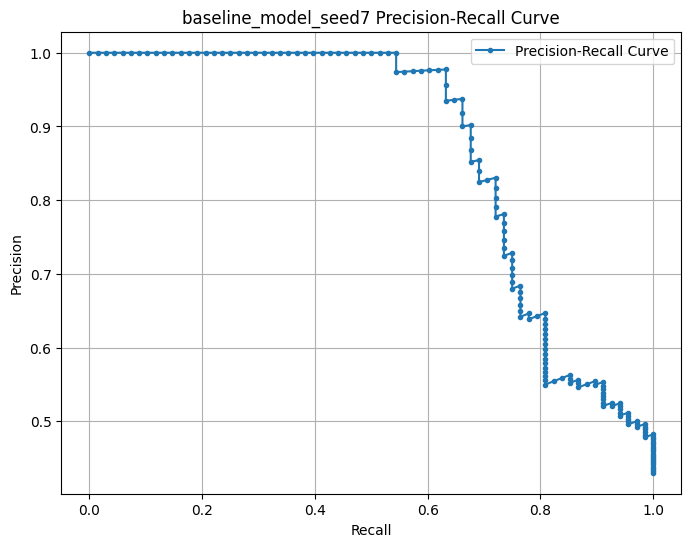

------------------------------


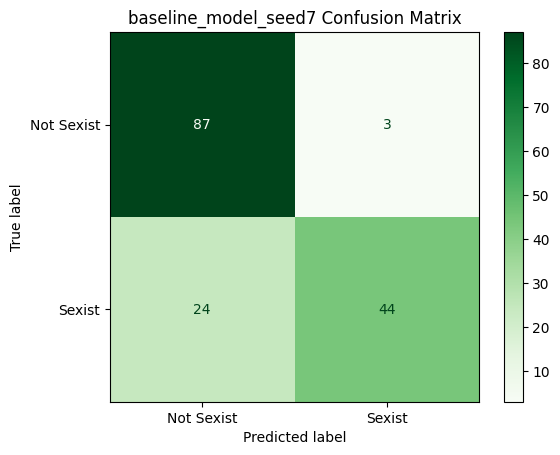

------------------------------
baseline_model_seed7 Misclassified Samples:
Tweet: I be hide in cat twitter mental health be really bad see a psychologist on friday I go to suicidal thought after be bully and harass by someone who be now no long a friend of mine or hobby
True Label: 0
Predicted Label: 1
--------------------
Tweet: I sincerely wish the us be this progressive on women right
True Label: 1
Predicted Label: 0
--------------------
Tweet: raise taxis and control
True Label: 1
Predicted Label: 0
--------------------
Tweet: freedom convoy toronto wave provide flagtheyre live in the wrong decade
True Label: 1
Predicted Label: 0
--------------------
Tweet: nearly 10 of student will encounter sexual misconduct at school to5b9hs39w
True Label: 1
Predicted Label: 0
--------------------
------------------------------


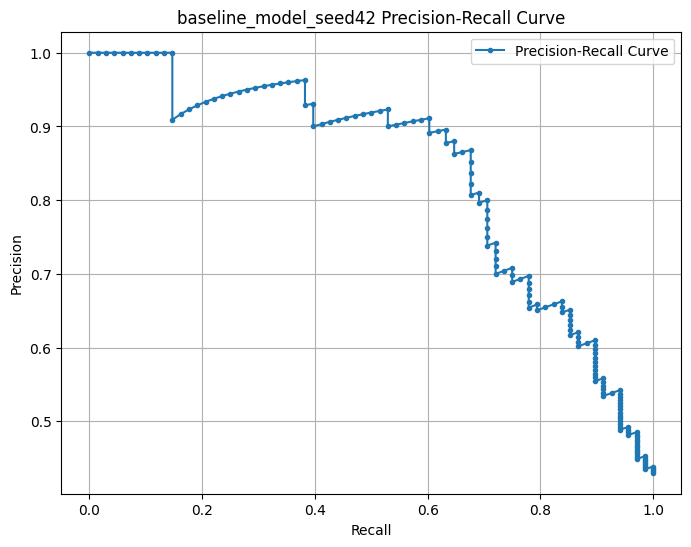

------------------------------


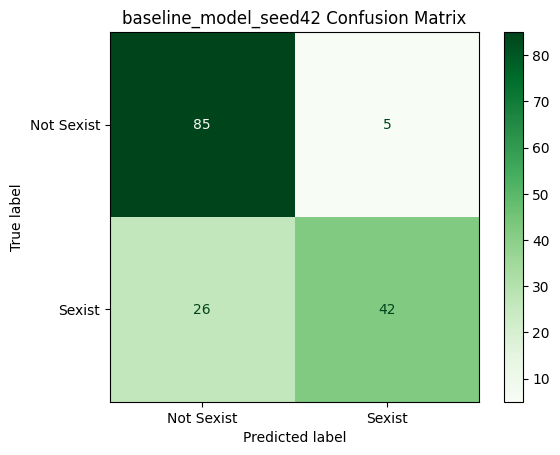

------------------------------
baseline_model_seed42 Misclassified Samples:
Tweet: I sincerely wish the us be this progressive on women right
True Label: 1
Predicted Label: 0
--------------------
Tweet: be you look for the perfect gift to show your mom or wife how much you love and appreciate she this mother day   mention our purerelief deluxe foot warm for optimal comfort holiness and relaxation click the link to learn more
True Label: 0
Predicted Label: 1
--------------------
Tweet: raise taxis and control
True Label: 1
Predicted Label: 0
--------------------
Tweet: freedom convoy toronto wave provide flagtheyre live in the wrong decade
True Label: 1
Predicted Label: 0
--------------------
Tweet: nearly 10 of student will encounter sexual misconduct at school to5b9hs39w
True Label: 1
Predicted Label: 0
--------------------
------------------------------


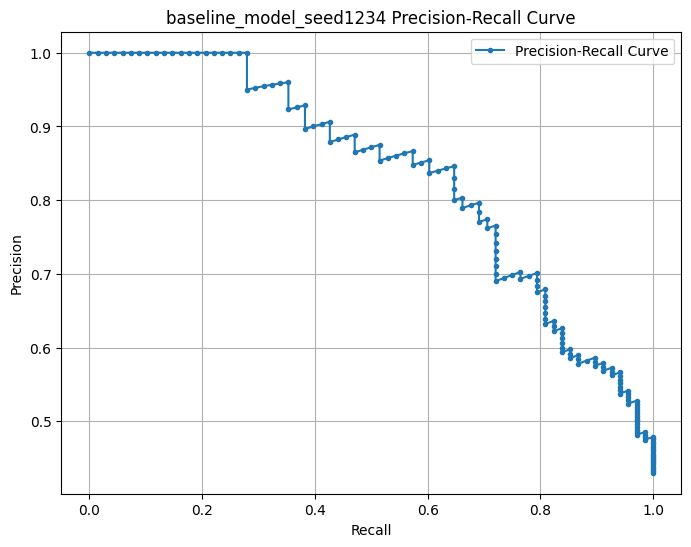

------------------------------


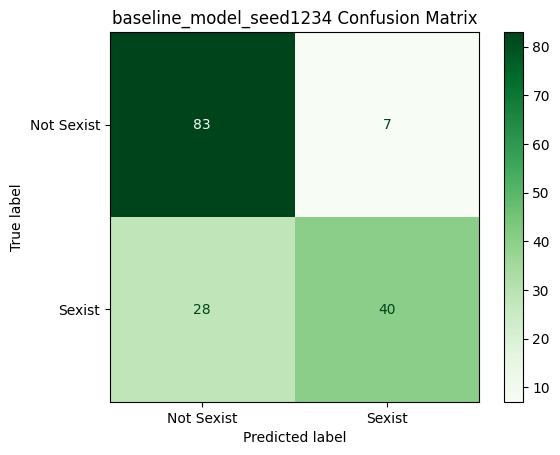

------------------------------
baseline_model_seed1234 Misclassified Samples:
Tweet: you should smile more love just pretend you re a tory open a food bank be only live through the bad   in living memory so its all a bit of a single cheer up darling it might never happen
True Label: 0
Predicted Label: 1
--------------------
Tweet: I sincerely wish the us be this progressive on women right
True Label: 1
Predicted Label: 0
--------------------
Tweet: be you look for the perfect gift to show your mom or wife how much you love and appreciate she this mother day   mention our purerelief deluxe foot warm for optimal comfort holiness and relaxation click the link to learn more
True Label: 0
Predicted Label: 1
--------------------
Tweet: raise taxis and control
True Label: 1
Predicted Label: 0
--------------------
Tweet: freedom convoy toronto wave provide flagtheyre live in the wrong decade
True Label: 1
Predicted Label: 0
--------------------


In [ ]:
for i in range(len(random_seeds)):
  name = "baseline_model_seed" + str(random_seeds[i])
  error_analysis(name, val_df, true_labels = true_labels, predictions = np.array(baseline_predict[i]))

------------------------------


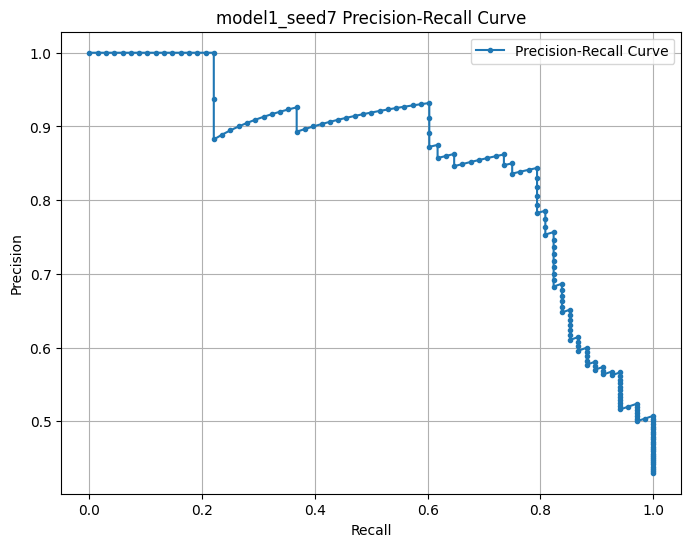

------------------------------


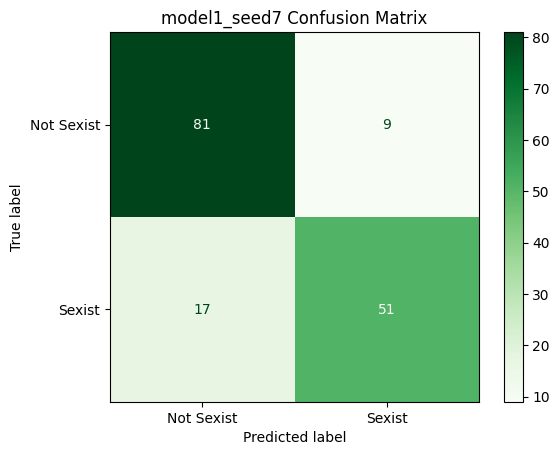

------------------------------
model1_seed7 Misclassified Samples:
Tweet: get twitter harass for pro choice
True Label: 1
Predicted Label: 0
--------------------
Tweet: wish all of you a very happy women day
True Label: 0
Predicted Label: 1
--------------------
Tweet: raise taxis and control
True Label: 1
Predicted Label: 0
--------------------
Tweet: freedom convoy toronto wave provide flagtheyre live in the wrong decade
True Label: 1
Predicted Label: 0
--------------------
Tweet: nearly 10 of student will encounter sexual misconduct at school to5b9hs39w
True Label: 1
Predicted Label: 0
--------------------
------------------------------


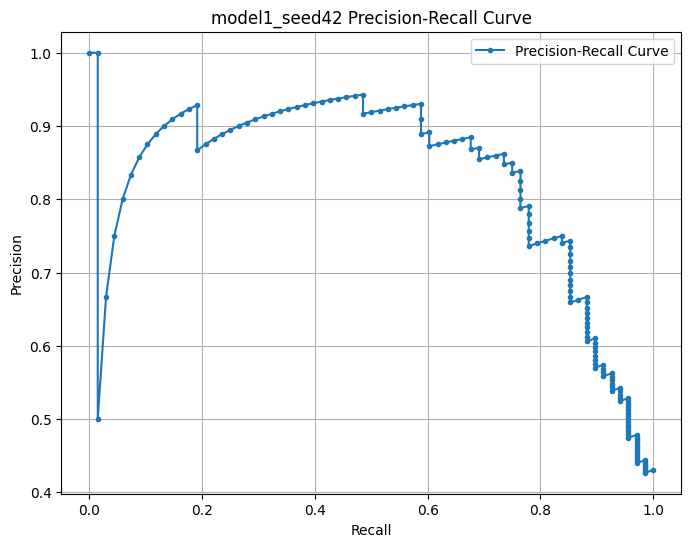

------------------------------


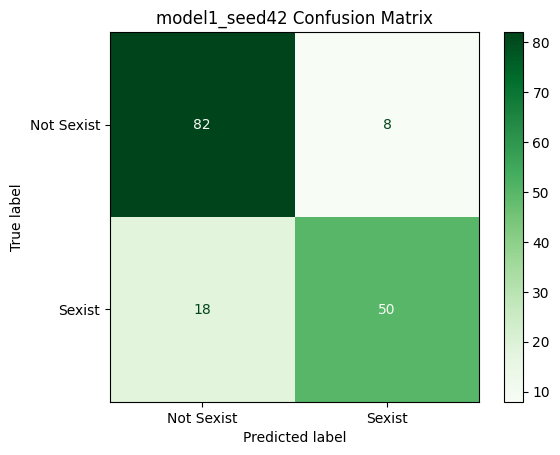

------------------------------
model1_seed42 Misclassified Samples:
Tweet: be you look for the perfect gift to show your mom or wife how much you love and appreciate she this mother day   mention our purerelief deluxe foot warm for optimal comfort holiness and relaxation click the link to learn more
True Label: 0
Predicted Label: 1
--------------------
Tweet: wish all of you a very happy women day
True Label: 0
Predicted Label: 1
--------------------
Tweet: raise taxis and control
True Label: 1
Predicted Label: 0
--------------------
Tweet: freedom convoy toronto wave provide flagtheyre live in the wrong decade
True Label: 1
Predicted Label: 0
--------------------
Tweet: nearly 10 of student will encounter sexual misconduct at school to5b9hs39w
True Label: 1
Predicted Label: 0
--------------------
------------------------------


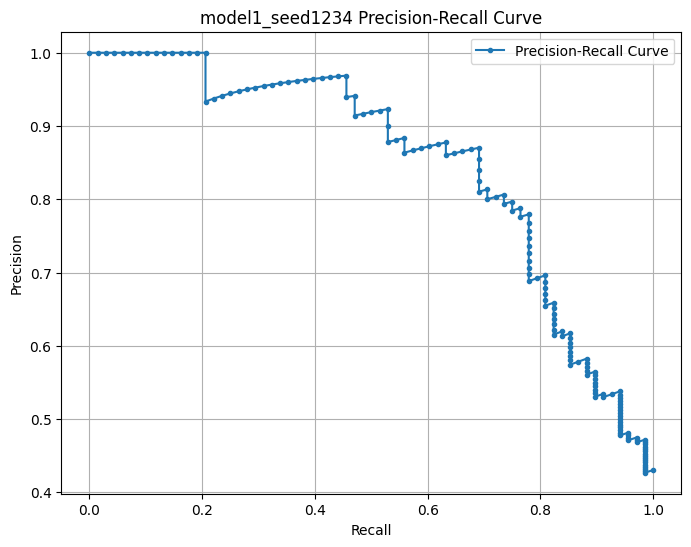

------------------------------


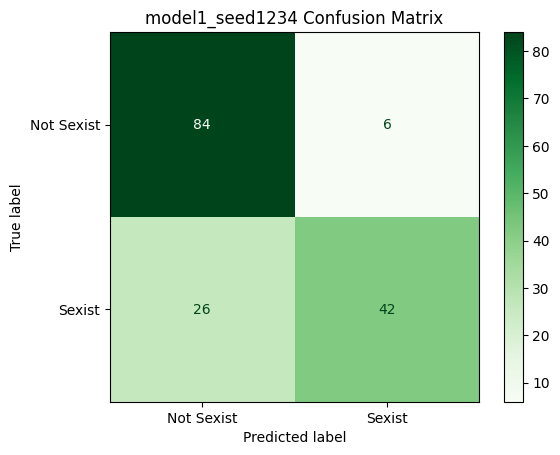

------------------------------
model1_seed1234 Misclassified Samples:
Tweet: some man move my suitcase in the overhead luggage storage on a train to what he think be a well position why and now completely out of my reach for when I have to rush off the train in a couple of stop woman can not arrange their own luggage apparently
True Label: 1
Predicted Label: 0
--------------------
Tweet: I sincerely wish the us be this progressive on women right
True Label: 1
Predicted Label: 0
--------------------
Tweet: raise taxis and control
True Label: 1
Predicted Label: 0
--------------------
Tweet: freedom convoy toronto wave provide flagtheyre live in the wrong decade
True Label: 1
Predicted Label: 0
--------------------
Tweet: nearly 10 of student will encounter sexual misconduct at school to5b9hs39w
True Label: 1
Predicted Label: 0
--------------------


In [ ]:
for i in range(len(random_seeds)):
  name = "model1_seed" + str(random_seeds[i])
  error_analysis(name, val_df, true_labels, model1_predict[i])

In [ ]:
error_analysis_df = val_df[['tweet', 'hard_label_task1']].copy()
error_analysis_df.rename(columns={'hard_label_task1': 'true_label'}, inplace=True)


baseline_seed7_pred = (np.array(baseline_predict[0]) >= 0.5).astype(int)
error_analysis_df['baseline_prediction_seed7'] = baseline_seed7_pred
baseline_seed42_pred = (np.array(baseline_predict[1]) >= 0.5).astype(int)
error_analysis_df['baseline_prediction_seed42'] = baseline_seed42_pred
baseline_seed1234_pred = (np.array(baseline_predict[2]) >= 0.5).astype(int)
error_analysis_df['baseline_prediction_seed1234'] = baseline_seed1234_pred
error_analysis_df['baseline_majority_vote'] = error_analysis_df[['baseline_prediction_seed7', 'baseline_prediction_seed42', 'baseline_prediction_seed1234']].mode(axis=1)[0]


model1_seed7_pred = (np.array(model1_predict[0]) >= 0.5).astype(int)
error_analysis_df['model1_prediction_seed7'] = model1_seed7_pred
model1_seed42_pred = (np.array(model1_predict[1]) >= 0.5).astype(int)
error_analysis_df['model1_prediction_seed42'] = model1_seed42_pred
model1_seed1234_pred = (np.array(model1_predict[2]) >= 0.5).astype(int)
error_analysis_df['model1_prediction_seed1234'] = model1_seed1234_pred
error_analysis_df['model1_majority_vote'] = error_analysis_df[['model1_prediction_seed7', 'model1_prediction_seed42', 'model1_prediction_seed1234']].mode(axis=1)[0]

error_analysis_df = error_analysis_df[["tweet","true_label","baseline_majority_vote","model1_majority_vote"]]
error_analysis_df.head()

,tweet,true_label,baseline_majority_vote,model1_majority_vote
400001,you should smile more love just pretend you re...,0,0,0
400002,she be right but the push be all in the opposi...,1,1,1
400003,some man move my suitcase in the overhead lugg...,1,1,1
400004,lol gamergate the go to boogieman maybe if the...,0,0,0
400005,to I this have the same negativity as gamergat...,0,0,0


# Transformers and Error analysis

In this section, you will use a transformer model specifically trained for hate speech detection, namely [Twitter-roBERTa-base for Hate Speech Detection](https://huggingface.co/cardiffnlp/twitter-roberta-base-hate).




### Instructions
1. **Load the Tokenizer and Model**

2. **Preprocess the Dataset**:
   You will need to preprocess your dataset to prepare it for input into the model. Tokenize your text data using the appropriate tokenizer and ensure it is formatted correctly.

   **Note**: You have to use the plain text of the dataset and not the version that you tokenized before, as you need to tokenize the cleaned text obtained after the initial cleaning process.

3. **Train the Model**:
   Use the `Trainer` to train the model on your training data.

4. **Evaluate the Model on the Test Set** using F1-macro.

In [ ]:
!pip install transformers datasets torch -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import Dataset
from transformers import TrainingArguments
from transformers import Trainer

MODEL_NAME = "cardiffnlp/twitter-roberta-base-hate"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)  # Binary classification

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/700 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
# Rename "hard_label_task1" to "label" in Pandas DataFrames
train_df = train_df.rename(columns={"hard_label_task1": "label"})
val_df = val_df.rename(columns={"hard_label_task1": "label"})
test_df = test_df.rename(columns={"hard_label_task1": "label"})

# Convert the Pandas DataFrames to HuggingFace datasets
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# Define a tokenization function
def tokenize_function(text):
    return tokenizer(text["tweet"], truncation=True)

# Apply tokenization to the datasets
train_encoded = train_dataset.map(tokenize_function, batched=True)
val_encoded = val_dataset.map(tokenize_function, batched=True)
test_encoded = test_dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/2870 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/158 [00:00<?, ? examples/s]

Map:   0%|          | 0/286 [00:00<?, ? examples/s]

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    f1_macro = f1_score(labels, predictions, average='macro')
    std = np.std([f1_score([true], [pred], average='macro') for true, pred in zip(labels, predictions)])
    accuracy = accuracy_score(labels, predictions)
    return {"f1_macro": f1_macro, "accuracy": accuracy, "Standard Deviation of F1 Scores": std}

In [ ]:
from transformers import EarlyStoppingCallback
seeds = [7, 42, 1234]


for seed in seeds:
    print(f"\n--- Training with seed {seed} ---\n")

    # Update TrainingArguments for each seed
    training_args = TrainingArguments(
        output_dir=f"./results_seed{seed}",  # Save results for each seed in a different folder
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=6,
        weight_decay=0.04,
        logging_dir=f'./logs_seed{seed}',  # Save logs for each seed
        save_total_limit=1,
        load_best_model_at_end=True,
        lr_scheduler_type='linear',
        seed=seed
    )

    early_stopping_callback = EarlyStoppingCallback(
            early_stopping_patience=2,
            early_stopping_threshold=0.01
    )

    # Create Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_encoded,
        eval_dataset=val_encoded,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[early_stopping_callback]
    )

    # Train the model
    trainer.train()

    # Save the final model
    model_path = f"./best_model_seed{seed}"
    trainer.save_model(model_path)
    name = "transformer_prediction_seed" + str(seed)
    predictions = trainer.predict(val_encoded)
    error_analysis_df[name] = np.argmax(predictions.predictions, axis=1)
    print(f"Best model for seed {seed} saved to {model_path}\n")



--- Training with seed 7 ---



/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-60-7cda5617df21>:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,F1 Macro,Accuracy,Standard deviation of f1 scores
1,No log,0.327987,0.889169,0.892405,0.309868
2,No log,0.414335,0.848602,0.854430,0.352674
3,0.306900,0.624202,0.843920,0.854430,0.352674


Best model for seed 7 saved to ./best_model_seed7


--- Training with seed 42 ---



/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-60-7cda5617df21>:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1 Macro,Accuracy,Standard deviation of f1 scores
1,No log,0.446988,0.840726,0.848101,0.358923
2,No log,0.490924,0.873541,0.879747,0.325257
3,0.207100,0.850498,0.833607,0.841772,0.364955


Best model for seed 42 saved to ./best_model_seed42


--- Training with seed 1234 ---



/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-60-7cda5617df21>:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1 Macro,Accuracy,Standard deviation of f1 scores
1,No log,0.508326,0.861767,0.867089,0.339479
2,No log,0.686581,0.851279,0.854430,0.352674
3,0.133600,0.923721,0.853999,0.860759,0.346197


Best model for seed 1234 saved to ./best_model_seed1234



In [ ]:
error_analysis_df['transformer_majority_vote'] = error_analysis_df[['transformer_prediction_seed7', 'transformer_prediction_seed42', 'transformer_prediction_seed1234']].mode(axis=1)[0]
error_analysis_df = error_analysis_df[["tweet","true_label","baseline_majority_vote","model1_majority_vote", "transformer_majority_vote"]]

In [ ]:
error_analysis_df.to_csv("error_analysis", index=False)
error_analysis_df.head()

,tweet,true_label,baseline_majority_vote,model1_majority_vote,transformer_majority_vote
400001,you should smile more love just pretend you re...,0,0,0,0
400002,she be right but the push be all in the opposi...,1,1,1,1
400003,some man move my suitcase in the overhead lugg...,1,1,1,1
400004,lol gamergate the go to boogieman maybe if the...,0,0,0,0
400005,to I this have the same negativity as gamergat...,0,0,0,0


In [ ]:
def evaluate_and_print_misclassifications(model_path, test_dataset, test_texts, seed):
    print(f"\n--- Evaluating Model from Seed {seed} ---")

    model_transformer = model.from_pretrained(model_path).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

    trainer = Trainer(model=model_transformer, tokenizer=tokenizer)

    predictions = trainer.predict(test_dataset)
    final_metrics = compute_metrics([predictions.predictions, predictions.label_ids])
    preds = np.argmax(predictions.predictions, axis=1)
    true_labels = predictions.label_ids

    # Generate confusion matrix
    cm = confusion_matrix(true_labels, preds)
    print(f"\nConfusion Matrix for Seed {seed}:\n")
    print(final_metrics)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Non-Sexist", "Sexist"], yticklabels=["Non-Sexist", "Sexist"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix for Seed {seed}")
    plt.show()

    # Print Classification Report
    print("\nClassification Report:")
    print(classification_report(true_labels, preds, target_names=["Non-Sexist", "Sexist"]))

    # Identify misclassified tweets
    misclassified_indices = np.where(preds != true_labels)[0]
    print(f"\nMisclassified Tweets for Seed {seed}:")
    for i in misclassified_indices:
        print(f"Tweet: {test_texts[i]}")
        print(f"True Label: {1 if true_labels[i] == 1 else 0}, Predicted: {1 if preds[i] == 1 else 0}\n")



--- Evaluating Model from Seed 7 ---


<ipython-input-67-56899d4d6fa2>:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model_transformer, tokenizer=tokenizer)



Confusion Matrix for Seed 7:

{'f1_macro': 0.8373714398734178, 'accuracy': 0.8391608391608392, 'Standard Deviation of F1 Scores': 0.3673825324912922}


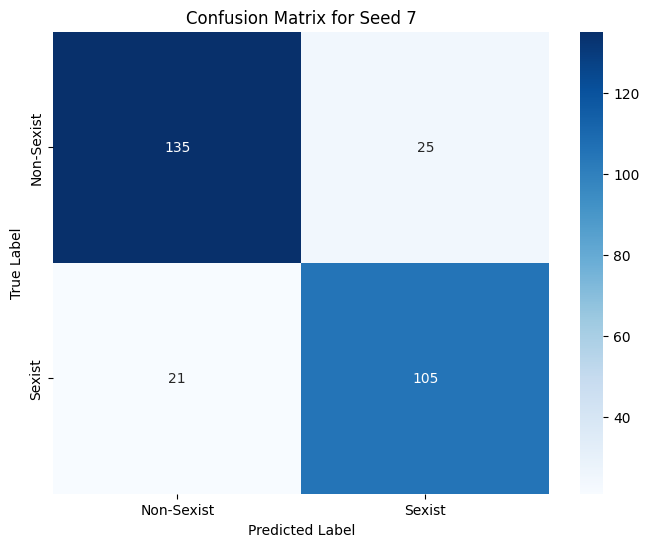


Classification Report:
              precision    recall  f1-score   support

  Non-Sexist       0.87      0.84      0.85       160
      Sexist       0.81      0.83      0.82       126

    accuracy                           0.84       286
   macro avg       0.84      0.84      0.84       286
weighted avg       0.84      0.84      0.84       286


Misclassified Tweets for Seed 7:
Tweet: sex as in gender harassment be what they be refer
True Label: 0, Predicted: 1

Tweet: appreciate be include along with   on the value gunman history of cyber gender harassment regrettable shocking
True Label: 0, Predicted: 1

Tweet: the violent antisemitism of a freight movement that see   principally as vessel for breed a new white generation express itself in a fixation on return to traditional gender rolesworth every minute to read   take 5 min out of your sun
True Label: 1, Predicted: 0

Tweet: ah look gender role be back too the do not believe their own lie
True Label: 1, Predicted: 0

Tweet: how

<ipython-input-67-56899d4d6fa2>:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model_transformer, tokenizer=tokenizer)



Confusion Matrix for Seed 42:

{'f1_macro': 0.8382034632034632, 'accuracy': 0.8391608391608392, 'Standard Deviation of F1 Scores': 0.3673825324912922}


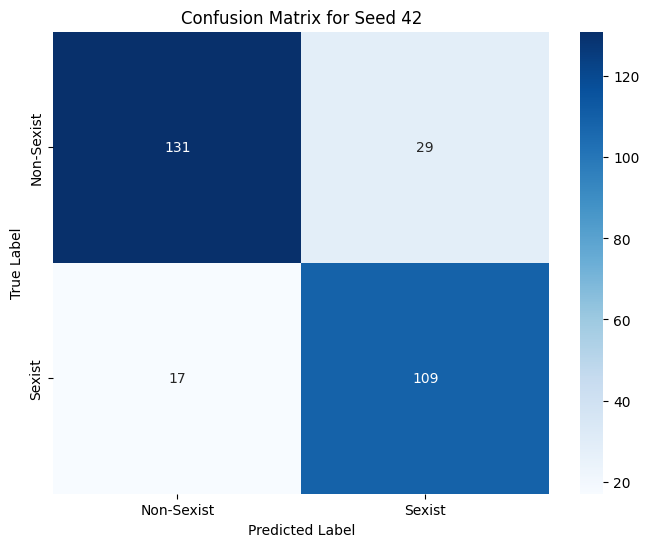


Classification Report:
              precision    recall  f1-score   support

  Non-Sexist       0.89      0.82      0.85       160
      Sexist       0.79      0.87      0.83       126

    accuracy                           0.84       286
   macro avg       0.84      0.84      0.84       286
weighted avg       0.84      0.84      0.84       286


Misclassified Tweets for Seed 42:
Tweet: I mean I do but would not it be fun to get gangbange together
True Label: 0, Predicted: 1

Tweet: sex as in gender harassment be what they be refer
True Label: 0, Predicted: 1

Tweet: appreciate be include along with   on the value gunman history of cyber gender harassment regrettable shocking
True Label: 0, Predicted: 1

Tweet: the violent antisemitism of a freight movement that see   principally as vessel for breed a new white generation express itself in a fixation on return to traditional gender rolesworth every minute to read   take 5 min out of your sun
True Label: 1, Predicted: 0

Tweet: how d

<ipython-input-67-56899d4d6fa2>:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model_transformer, tokenizer=tokenizer)



Confusion Matrix for Seed 1234:

{'f1_macro': 0.8158767889862824, 'accuracy': 0.8181818181818182, 'Standard Deviation of F1 Scores': 0.38569460791993504}


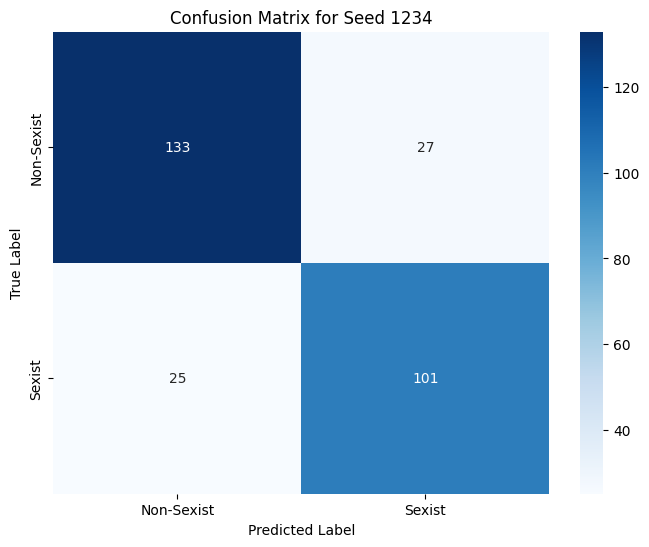


Classification Report:
              precision    recall  f1-score   support

  Non-Sexist       0.84      0.83      0.84       160
      Sexist       0.79      0.80      0.80       126

    accuracy                           0.82       286
   macro avg       0.82      0.82      0.82       286
weighted avg       0.82      0.82      0.82       286


Misclassified Tweets for Seed 1234:
Tweet: I mean I do but would not it be fun to get gangbange together
True Label: 0, Predicted: 1

Tweet: sex as in gender harassment be what they be refer
True Label: 0, Predicted: 1

Tweet: appreciate be include along with   on the value gunman history of cyber gender harassment regrettable shocking
True Label: 0, Predicted: 1

Tweet: ah look gender role be back too the do not believe their own lie
True Label: 1, Predicted: 0

Tweet: how do we reach a point where block be have the audacity to talk about yoongis rap do all see who you stan   be all ok   your girl can not write can not deliver can not come

In [ ]:
seeds = [7, 42, 1234]
for seed in seeds:
    model_path = f"./best_model_seed{seed}"
    evaluate_and_print_misclassifications(model_path, test_encoded, test_df["tweet"].tolist(), seed)

The best f1 socre in transformer model is:

 f1_macro: 0.8382034632034632

 Std of F1 Score: 0.3673825324912922

### Error Analysis

### Instructions

After evaluating the model, perform a brief error analysis:

 - Review the results and identify common errors.

 - Summarize your findings regarding the errors and their impact on performance (e.g. but not limited to Out-of-Vocabulary (OOV) words, data imbalance, and performance differences between the custom model and the transformer...)
 - Suggest possible solutions to address the identified errors.


### Some of analyses have been performed in the model definition and transformers sections, such as the confusion matrix, Precision/Recall curves and Specific misclassified samples..

### Find rows where the true label is different from at least one prediction

In [ ]:
# Find rows where the true label is different from at least one prediction
misclassified_rows = error_analysis_df[
    (error_analysis_df["true_label"] != error_analysis_df["baseline_majority_vote"]) |
    (error_analysis_df["true_label"] != error_analysis_df["model1_majority_vote"]) |
    (error_analysis_df["true_label"] != error_analysis_df["transformer_majority_vote"])
]

num_misclassified = len(misclassified_rows)
print(f"Number of misclassified rows: {num_misclassified}")

misclassified_rows.head()

Number of misclassified rows: 41


,tweet,true_label,baseline_majority_vote,model1_majority_vote,transformer_majority_vote
400008,get twitter harass for pro choice,1,1,1,0
400017,yo radical republicansamp member of the patria...,0,0,0,1
400021,I sincerely wish the us be this progressive on...,1,0,1,0
400026,be you look for the perfect gift to show your ...,0,1,0,0
400027,wish all of you a very happy women day,0,0,1,0


# Find rows where true_label is different from all baseline, model1, or transformer_majority_vote

In [ ]:

completely_wrong_rows = error_analysis_df[
    (error_analysis_df["true_label"] != error_analysis_df["baseline_majority_vote"]) &
    (error_analysis_df["true_label"] != error_analysis_df["model1_majority_vote"]) &
    (error_analysis_df["true_label"] != error_analysis_df["transformer_majority_vote"])
]
num_completely_wrong = len(completely_wrong_rows)
print(f"Number of rows where all predictions are wrong: {num_completely_wrong}")
completely_wrong_rows.head(10)

Number of rows where all predictions are wrong: 10


,tweet,true_label,baseline_majority_vote,model1_majority_vote,transformer_majority_vote
400029,raise taxis and control,1,0,0,0
400030,freedom convoy toronto wave provide flagtheyre...,1,0,0,0
400044,at first I be scared of he but after some stal...,1,0,0,0
400045,singer the play as good as a man bullshit get ...,1,0,0,0
400051,its call identity politic and subversive cultu...,1,0,0,0
400065,you should take a get pitch class,1,0,0,0
400066,talkie centricidehe scream french person raise...,1,0,0,0
400139,join we tomorrow at 2 pm for our be office ban...,1,0,0,0
400157,be be an acronym standing for sex workerexclus...,1,0,0,0
400176,this be your reminder that you can be child wo...,0,1,1,1


###Error Analysis(All Models Wrong)
###1. Out-of-Vocabulary (OOV) Words:

- Observation: There are several informal words and hashtags (e.g., "freedom convoy", "identity politic").
- Example Tweet: "freedom convoy toronto wave provide flagtheyre late" The tweet contains domain-specific phrases ("freedom convoy") which may not appear in the training data.
- Impact: The models may struggle to understand rare political hashtags or unique terms.
###2. Ambiguity and Sarcasm:
- Observation: Some tweets use sarcastic, figurative, or ambiguous language.
- Example Tweet: "singer the play as good as a man bullshit get a grip" The tweet can be interpreted as supporting or challenging sexism, depending on context.
- Impact: Sarcastic phrasing can confuse models trained on literal interpretations.
###3. Length-Based Errors:
- Observation: Some tweets are either very long or short with limited context.
- Example Tweet: "raise taxis and control" This short tweet lacks context, making it difficult for the model to infer meaning.
-Impact: Short tweets often do not provide enough clues for accurate predictions.
###4. Data Imbalance:
- Observation: If there are fewer "sexist" tweets in the training data, the model may lean towards predicting "non-sexist".
- Example Tweet: "its call identity politic and subversive culture war" Even though this may imply discrimination, the model predicts "non-sexist".
- Impact: The imbalance can cause the model to predict the majority class more often, leading to false negatives.
###5. Contextual References:
- Observation: Some tweets reference external political or cultural events without explicit sexist language.
- Example Tweet: "at first I be scared of he but after some stalemated chat we drink together" Without additional context, this appears neutral but could imply bias.
- Impact: Lack of external context limits the model’s understanding.


###Proposed Solutions

- Out-of-Vocabulary (OOV) Words solution: Enrich the training data with domain-specific hashtags, political terms, and informal expressions commonly found in tweets.
- Ambiguity and Sarcasm solution: Enrich the training data with diverse examples of sarcastic, ambiguous, and figurative language to make the model more robust.
- Class Imbalance solution: Address potential data imbalance using techniques like oversampling the minority class (sexist tweets) or undersampling the majority class.
- Short and Long Tweets solution: Enhance LSTM-based models by using a sliding window approach for long tweets and aggregating predictions over multiple windows.
- Contextual References and External Knowledge solution: Incorporate external knowledge sources like Wikipedia or gender-bias lexicons to help the model understand external references.
- Majority Voting Between Annotators solution: Explore other methods beyond majority voting, such as weighted voting based on annotator reliability.
- Iterative Error Analysis solution: Perform continuous error analysis to iteratively refine the preprocessing, model, and evaluation strategies.
